# Neural Networks For Market Trading

In [1]:
import pandas as pd
#df = pd.read_csv("EURUSD_Candlestick_1_D_ASK_05.05.2003-30.06.2021.csv")
df = pd.read_csv("EURUSD-1D-062019-062020.csv")

#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

,Local time,open,high,low,close,volume
309,27.05.2020 00:00:00,1.09785,1.10307,1.09340,1.10166,319490.550300
310,28.05.2020 00:00:00,1.10165,1.10934,1.09916,1.10779,231205.203600
311,29.05.2020 00:00:00,1.10778,1.11451,1.10698,1.11036,373017.446900
312,31.05.2020 00:00:00,1.11129,1.11195,1.11023,1.11156,9217.483496
313,01.06.2020 00:00:00,1.11155,1.11540,1.11004,1.11251,240616.062700


# Support and Resistance FUNCTIONS

In [2]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.low[i]>df1.low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.low[i]<df1.low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.high[i]<df1.high[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.high[i]>df1.high[i-1]):
            return 0
    return 1

In [3]:
length = len(df)
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
open = list(df['open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and 
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and 
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.high[l]-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c2 = abs(max(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c3 = min(df.open[l],df.close[l])<min(levels, key=lambda x:abs(x-df.high[l]))
    c4 = df.low[l]<min(levels, key=lambda x:abs(x-df.high[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.low[l]-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c2 = abs(min(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c3 = max(df.open[l],df.close[l])>min(levels, key=lambda x:abs(x-df.low[l]))
    c4 = df.high[l]>min(levels, key=lambda x:abs(x-df.low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [4]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.high[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):#and df.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0



In [5]:
df['signal']=signal

In [6]:
df[df['signal']==1].count()

Local time    1
open          1
high          1
low           1
close         1
volume        1
signal        1
dtype: int64

In [7]:
df.columns = ['Local time', 'Open', 'High', 'Low', 'Close', 'Volume', 'signal']
df=df.iloc[100:200]
df

,Local time,Open,High,Low,Close,Volume,signal
100,26.09.2019 00:00:00,1.09511,1.09672,1.09087,1.09222,191177.028200,0
101,27.09.2019 00:00:00,1.09223,1.09586,1.09046,1.09367,176770.060400,0
102,29.09.2019 00:00:00,1.09419,1.09461,1.09391,1.09422,3943.520001,0
103,30.09.2019 00:00:00,1.09421,1.09478,1.08847,1.08993,175540.030300,0
104,01.10.2019 00:00:00,1.08992,1.09428,1.08790,1.09339,214512.270200,0
...,...,...,...,...,...,...,...
195,15.01.2020 00:00:00,1.11276,1.11634,1.11185,1.11524,149733.394800,0
196,16.01.2020 00:00:00,1.11524,1.11727,1.11279,1.11368,132785.065100,0
197,17.01.2020 00:00:00,1.11368,1.11425,1.10862,1.10890,123846.607700,0
198,19.01.2020 00:00:00,1.10910,1.10948,1.10889,1.10946,3275.469993,0


In [8]:
def SIGNAL():
    return df.signal

In [9]:
#A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().
#Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient, 
#vectorized manner whatever indicators and signals the strategy depends on.
#Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row), 
#simulating the incremental availability of each new full candlestick bar.

#Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the
#next candle's open (or the current candle's close if trade_on_close=True). 
#If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin 
#with more fine-grained (e.g. hourly) data.

In [10]:
from backtesting import Strategy

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 600e-4
            tp1 = self.data.Close[-1] + 450e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 600e-4
            tp1 = self.data.Close[-1] - 450e-4
            self.sell(sl=sl1, tp=tp1)

C:\work fin\venv\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [11]:
from backtesting import Backtest

bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
stat = bt.run()
stat



C:\Users\o00494123\AppData\Local\Temp\ipykernel_89020\3652353141.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)


Start                                   100.0
End                                     199.0
Duration                                 99.0
Exposure Time [%]                        94.0
Equity Final [$]                  10122.43066
Equity Peak [$]                   10235.73832
Return [%]                           1.224307
Buy & Hold Return [%]                1.593086
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.481487
Avg. Drawdown [%]                   -0.773422
Max. Drawdown Duration                   47.0
Avg. Drawdown Duration                   16.8
# Trades                                  1.0
Win Rate [%]                            100.0
Best Trade [%]                       1.224408
Worst Trade [%]                      1.224408
Avg. Trade [%]                    

In [12]:
bt.plot()

GridPlot(id='p1307', ...)

In [13]:
#Target flexible way
pipdiff = 250*1e-4 #for TP
SLTPRatio = 1 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        #if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 2 # bth limits exceeded
        #elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 3 #-1 downtrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
        #    trendcat[line] = 1 # uptrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 0 # no trend
        #elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 5 # light trend down
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 4 # light trend up
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<Axes: >

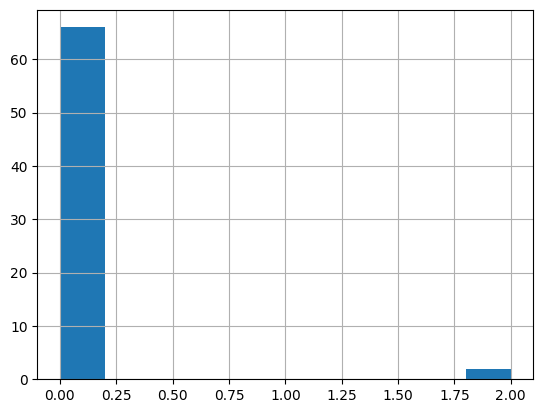

In [14]:
#!!! pitfall one category high frequency
df['Target'] = mytarget(30, df)
#df.tail(20)
#df['Target'] = df['Target'].astype(int)
df['Target'].hist()

In [15]:
import pandas_ta as pa
df["RSI"] = pa.rsi(df.Close, length=16)
df.tail(20)

,Local time,Open,High,Low,Close,Volume,signal,Target,RSI
180,29.12.2019 00:00:00,1.11736,1.11839,1.11718,1.11813,3216.499400,0,NaN,63.278426
181,30.12.2019 00:00:00,1.11812,1.12207,1.11806,1.12013,130773.875100,0,NaN,65.497182
182,31.12.2019 00:00:00,1.12013,1.12391,1.11987,1.12076,107776.560100,0,NaN,66.183703
183,01.01.2020 00:00:00,1.12106,1.12218,1.12106,1.12188,2612.320002,0,NaN,67.413253
184,02.01.2020 00:00:00,1.12188,1.12245,1.11635,1.11708,487219.118000,0,NaN,57.805131
185,03.01.2020 00:00:00,1.11707,1.11798,1.11249,1.11548,177406.790300,0,NaN,55.017095
186,05.01.2020 00:00:00,1.11656,1.11677,1.11589,1.11604,4398.100001,0,NaN,55.812752
187,06.01.2020 00:00:00,1.11603,1.12055,1.11571,1.11954,139965.285100,0,NaN,60.473689
188,07.01.2020 00:00:00,1.11953,1.11970,1.11335,1.11540,155594.095300,0,NaN,53.370714
189,08.01.2020 00:00:00,1.11539,1.11682,1.11016,1.11129,195256.950100,0,NaN,47.466873


In [16]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

            Open       High        Low      Close         Volume     signal   
count  52.000000  52.000000  52.000000  52.000000      52.000000  52.000000  \
mean    1.107714   1.109745   1.105681   1.107868  114093.445780   0.019231   
std     0.005098   0.005400   0.004666   0.005124   57760.763476   0.138675   
min     1.100490   1.101790   1.098110   1.100480    1359.570004   0.000000   
25%     1.102510   1.105235   1.101628   1.103142  108355.137700   0.000000   
50%     1.107385   1.109210   1.105940   1.107495  121028.849200   0.000000   
75%     1.111505   1.114157   1.107950   1.111915  138464.684050   0.000000   
max     1.118330   1.119950   1.116390   1.118330  232685.870300   1.000000   

       Target        RSI  
count    52.0  52.000000  
mean      0.0  57.108070  
std       0.0  13.165129  
min       0.0  40.351852  
25%       0.0  44.275821  
50%       0.0  55.379755  
75%       0.0  66.177483  
max       0.0  86.998749  


In [17]:
attributes = ['RSI', 'signal', 'Target']
df_model= df[attributes].copy()

df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix = 'signalcategory')
df_model= df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,RSI,Target,signalcategory_0,signalcategory_1
0,73.932636,0.0,True,False
1,79.494808,0.0,True,False
2,84.149031,0.0,True,False
3,86.998749,0.0,True,False
4,82.029398,0.0,True,False
5,80.573575,0.0,True,False
6,73.282250,0.0,True,False
7,73.653588,0.0,True,False
8,65.215780,0.0,True,False
9,59.097480,0.0,True,False


In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

KeyError: "['signalcategory_2'] not in index"

In [147]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[   0   39  212]
 [   0  416  853]
 [   0  161 1273]]
[[  0  73 364]
 [  0  69 317]
 [  0 101 342]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       251
         1.0       0.68      0.33      0.44      1269
         2.0       0.54      0.89      0.67      1434

    accuracy                           0.57      2954
   macro avg       0.41      0.41      0.37      2954
weighted avg       0.55      0.57      0.52      2954

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       437
         1.0       0.28      0.18      0.22       386
         2.0       0.33      0.77      0.47       443

    accuracy                           0.32      1266
   macro avg       0.21      0.32      0.23      1266
weighted avg       0.20      0.32      0.23      1266

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


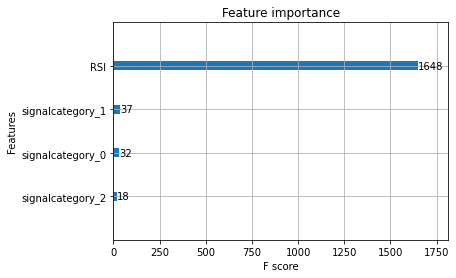

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


In [120]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)

In [38]:
from sklearn.neural_network import MLPClassifier

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.6 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

NN = MLPClassifier(hidden_layer_sizes=(50, 50, 60, 30, 9), random_state=100, verbose=0, max_iter=1000, activation='relu')
NN.fit(X_train, y_train)
pred_train = NN.predict(X_train)
pred_test = NN.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("="*20)

print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test)) 

****Train Results****
Accuracy: 52.8637%
****Test Results****
Accuracy: 34.9867%


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)